In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: Load and prepare data

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
subscales = {
    '7u':    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q13'],
    '7d':    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q12','7u7d-q14'],
    'gad7':  ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],
    'bis':   ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    'bas':   ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08',
              'bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    'shaps': ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
              'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
              'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
}

## Define max response option per scale (0-indexed).
scale_max = [3,3,3,3,3,3]
scale_min = [0,0,0,0,0,0]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load reject data.
reject = read_csv(os.path.join('data','reject.csv'))

## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(reject.subject)]

## Iteratively compute sum scores.
for i, (k, v) in enumerate(subscales.items()):
    min_score = len(v) * scale_min[i]
    max_score = len(v) * scale_max[i]
    surveys[k] = (surveys[v].sum(axis=1) - min_score) / (max_score - min_score)
    
## Merge infrequency items.
surveys = surveys.merge(reject[['platform','subject','infreq']])
surveys['infreq'] = np.where(surveys['infreq'], 1, 0)

## Melt DataFrame.
scores = surveys.melt(id_vars=['platform','subject','infreq'], value_vars=subscales.keys(),
                      var_name='survey', value_name='score')

## Section 2: Visualization

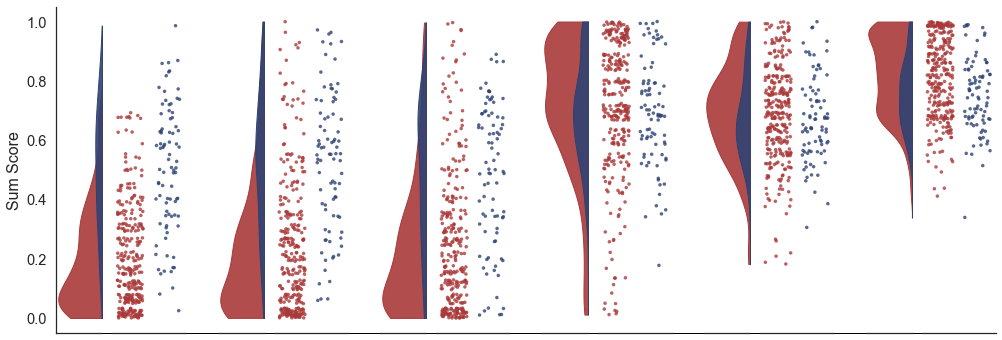

In [3]:
from matplotlib import lines

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig = plt.figure(figsize=(15,6), constrained_layout=False)

## Predefine grids.
grids = [
    fig.add_gridspec(nrows=1, ncols=5, left=0.06, right=0.18, wspace=0.5),
    fig.add_gridspec(nrows=1, ncols=5, left=0.21, right=0.33, wspace=0.5),
    fig.add_gridspec(nrows=1, ncols=5, left=0.36, right=0.48, wspace=0.5),
    fig.add_gridspec(nrows=1, ncols=5, left=0.51, right=0.63, wspace=0.5),
    fig.add_gridspec(nrows=1, ncols=5, left=0.66, right=0.78, wspace=0.5),
    fig.add_gridspec(nrows=1, ncols=5, left=0.81, right=0.93, wspace=0.5),
]

for i, survey in enumerate(scores.survey.unique()):
    
    ## Restrict DataFrame.
    df = scores.query(f'survey=="{survey}"').copy()
    
    ## Jitter data.
    unit = np.abs(df.score.diff()).sort_values().unique()[1]
    jitter = lambda x: np.random.uniform(0, unit*0.7, x.size)
    df['jscore'] = np.where(df.score==1, df.score - jitter(df.score), df.score + jitter(df.score))
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Distribution plots.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize axis.
    ax = fig.add_subplot(grids[i][:2])
    
    ## Plot distribution of scores.
    sns.kdeplot(y='jscore', hue='infreq', data=df, hue_order=[1,0], common_grid=True,
                palette=['#2E4272','#AA3939'], fill=True, cut=0, alpha=0.9, legend=False, ax=ax)
    
    ## Invert x-axis.
    ax.invert_xaxis()
    
    ## Add details.
    ax.set(xticks=[], xlabel='', ylim=(-0.05,1.05), yticks=[], ylabel='')
    sns.despine(left=True, ax=ax)
    
    if not i: 
        ax.set(yticks=np.linspace(0,1,6), ylabel='Sum Score')
        sns.despine(ax=ax)
        ax.axhline(-0.05, 0, 20, color='k', lw=1, clip_on=False, zorder=-1)
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Point plots.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize axis.
    ax = fig.add_subplot(grids[i][2:])
    
    ## Plot individual scores.
    sns.stripplot(x='infreq', y='jscore', data=df, order=[0,1], orient='v', palette=['#AA3939','#2E4272'],
                   size=3.5, alpha=0.8, jitter=0.35, zorder=-1, ax=ax)
    
    ## Add details.
    ax.set(xticks=[], xlabel='', ylim=(-0.05,1.05), yticks=[], ylabel='')
    sns.despine(left=True, ax=ax)
    
# plt.savefig('test.png', dpi=180)